In [1]:
%pip install numpy pandas scikit-learn seaborn matplotlib xgboost deap imbalanced-learn --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Comparative Study Between Ensemble Learning and Evolutionary Learning to solve the Higgs Bozon Detection

In [31]:
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import xgboost as xgb
from deap import base, creator, tools, gp, algorithms


import matplotlib.pyplot as plt

## Data loading

In [3]:
dataFilename = './atlas-higgs.csv'
data = pd.read_csv(dataFilename)

print(data.shape)
print(data.dtypes)

(818238, 35)
EventId                          int64
DER_mass_MMC                   float64
DER_mass_transverse_met_lep    float64
DER_mass_vis                   float64
DER_pt_h                       float64
DER_deltaeta_jet_jet           float64
DER_mass_jet_jet               float64
DER_prodeta_jet_jet            float64
DER_deltar_tau_lep             float64
DER_pt_tot                     float64
DER_sum_pt                     float64
DER_pt_ratio_lep_tau           float64
DER_met_phi_centrality         float64
DER_lep_eta_centrality         float64
PRI_tau_pt                     float64
PRI_tau_eta                    float64
PRI_tau_phi                    float64
PRI_lep_pt                     float64
PRI_lep_eta                    float64
PRI_lep_phi                    float64
PRI_met                        float64
PRI_met_phi                    float64
PRI_met_sumet                  float64
PRI_jet_num                      int64
PRI_jet_leading_pt             float64
PRI_jet_lead

In [4]:
data.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,b,t,6.245333


## Data cleaning

In [5]:
del(data['EventId'])
del(data['Weight'])
del(data['KaggleSet'])
del(data['KaggleWeight'])

Encoder = LabelEncoder()

data['Label'] = Encoder.fit_transform(data['Label'])

data

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label
0,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,197.760,...,258.733,2,67.435,2.150,0.444,46.062,1.240,-2.475,113.497,1
1,160.937,68.768,103.235,48.146,-999.000,-999.000,-999.000,3.473,2.078,125.157,...,164.546,1,46.226,0.725,1.158,-999.000,-999.000,-999.000,46.226,0
2,-999.000,162.172,125.953,35.635,-999.000,-999.000,-999.000,3.148,9.336,197.814,...,260.414,1,44.251,2.053,-2.028,-999.000,-999.000,-999.000,44.251,0
3,143.905,81.417,80.943,0.414,-999.000,-999.000,-999.000,3.310,0.414,75.968,...,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,0
4,175.864,16.915,134.805,16.405,-999.000,-999.000,-999.000,3.891,16.405,57.983,...,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818233,105.668,46.443,60.048,156.191,0.403,47.746,0.936,1.279,6.133,256.853,...,303.668,2,112.264,1.190,-0.766,41.791,0.787,-1.090,154.056,1
818234,99.294,30.097,62.713,65.861,3.312,471.319,-2.611,2.294,2.889,248.582,...,266.919,2,108.698,1.293,-0.868,70.158,-2.018,2.893,178.856,1
818235,108.497,9.837,65.149,18.006,-999.000,-999.000,-999.000,2.742,18.006,68.097,...,188.648,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,0
818236,96.711,20.006,66.942,29.761,-999.000,-999.000,-999.000,2.479,2.739,101.676,...,212.565,1,30.863,1.460,2.637,-999.000,-999.000,-999.000,30.863,0


## Handling missing values

Missing data in this file are designated -999.

In [6]:
negative_999_counts = (data == -999).sum()

print(negative_999_counts)

DER_mass_MMC                   124602
DER_mass_transverse_met_lep         0
DER_mass_vis                        0
DER_pt_h                            0
DER_deltaeta_jet_jet           580253
DER_mass_jet_jet               580253
DER_prodeta_jet_jet            580253
DER_deltar_tau_lep                  0
DER_pt_tot                          0
DER_sum_pt                          0
DER_pt_ratio_lep_tau                0
DER_met_phi_centrality              0
DER_lep_eta_centrality         580253
PRI_tau_pt                          0
PRI_tau_eta                         0
PRI_tau_phi                         0
PRI_lep_pt                          0
PRI_lep_eta                         0
PRI_lep_phi                         0
PRI_met                             0
PRI_met_phi                         0
PRI_met_sumet                       0
PRI_jet_num                         0
PRI_jet_leading_pt             327371
PRI_jet_leading_eta            327371
PRI_jet_leading_phi            327371
PRI_jet_subl

In [7]:
imputer = SimpleImputer(missing_values=-999, strategy='mean')

columns = data.columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

data[numeric_cols] = imputer.fit_transform(data[numeric_cols])

data

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label
0,138.470000,51.655,97.827,27.980,0.910000,124.71100,2.66600,3.064,41.928,197.760,...,258.733,2.0,67.435000,2.150000,0.444000,46.062000,1.240000,-2.47500,113.497,1.0
1,160.937000,68.768,103.235,48.146,2.404626,372.18105,-0.82874,3.473,2.078,125.157,...,164.546,1.0,46.226000,0.725000,1.158000,57.810286,-0.006669,-0.01047,46.226,0.0
2,121.867697,162.172,125.953,35.635,2.404626,372.18105,-0.82874,3.148,9.336,197.814,...,260.414,1.0,44.251000,2.053000,-2.028000,57.810286,-0.006669,-0.01047,44.251,0.0
3,143.905000,81.417,80.943,0.414,2.404626,372.18105,-0.82874,3.310,0.414,75.968,...,86.062,0.0,84.904285,-0.001248,-0.018856,57.810286,-0.006669,-0.01047,-0.000,0.0
4,175.864000,16.915,134.805,16.405,2.404626,372.18105,-0.82874,3.891,16.405,57.983,...,53.131,0.0,84.904285,-0.001248,-0.018856,57.810286,-0.006669,-0.01047,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818233,105.668000,46.443,60.048,156.191,0.403000,47.74600,0.93600,1.279,6.133,256.853,...,303.668,2.0,112.264000,1.190000,-0.766000,41.791000,0.787000,-1.09000,154.056,1.0
818234,99.294000,30.097,62.713,65.861,3.312000,471.31900,-2.61100,2.294,2.889,248.582,...,266.919,2.0,108.698000,1.293000,-0.868000,70.158000,-2.018000,2.89300,178.856,1.0
818235,108.497000,9.837,65.149,18.006,2.404626,372.18105,-0.82874,2.742,18.006,68.097,...,188.648,0.0,84.904285,-0.001248,-0.018856,57.810286,-0.006669,-0.01047,-0.000,0.0
818236,96.711000,20.006,66.942,29.761,2.404626,372.18105,-0.82874,2.479,2.739,101.676,...,212.565,1.0,30.863000,1.460000,2.637000,57.810286,-0.006669,-0.01047,30.863,0.0


In [8]:
negative_999_counts = (data == -999).sum()

print(negative_999_counts)

DER_mass_MMC                   0
DER_mass_transverse_met_lep    0
DER_mass_vis                   0
DER_pt_h                       0
DER_deltaeta_jet_jet           0
DER_mass_jet_jet               0
DER_prodeta_jet_jet            0
DER_deltar_tau_lep             0
DER_pt_tot                     0
DER_sum_pt                     0
DER_pt_ratio_lep_tau           0
DER_met_phi_centrality         0
DER_lep_eta_centrality         0
PRI_tau_pt                     0
PRI_tau_eta                    0
PRI_tau_phi                    0
PRI_lep_pt                     0
PRI_lep_eta                    0
PRI_lep_phi                    0
PRI_met                        0
PRI_met_phi                    0
PRI_met_sumet                  0
PRI_jet_num                    0
PRI_jet_leading_pt             0
PRI_jet_leading_eta            0
PRI_jet_leading_phi            0
PRI_jet_subleading_pt          0
PRI_jet_subleading_eta         0
PRI_jet_subleading_phi         0
PRI_jet_all_pt                 0
Label     

## Data calibration

In [9]:
scaler = MinMaxScaler()

data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

data

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label
0,0.066707,0.053326,0.068128,0.009869,0.104310,0.022395,0.591293,0.515244,0.014789,0.074595,...,0.112586,0.666667,0.033028,0.738889,0.570656,0.020388,0.637778,0.106143,0.061014,1.0
1,0.078287,0.070992,0.072155,0.016983,0.275633,0.072274,0.495970,0.589031,0.000733,0.038884,...,0.069314,0.333333,0.014316,0.580556,0.684278,0.035301,0.499259,0.498334,0.024850,0.0
2,0.058150,0.167417,0.089071,0.012570,0.275633,0.072274,0.495970,0.530399,0.003293,0.074622,...,0.113359,0.333333,0.012573,0.728111,0.177276,0.035301,0.499259,0.498334,0.023789,0.0
3,0.069508,0.084050,0.055557,0.000146,0.275633,0.072274,0.495970,0.559625,0.000146,0.014690,...,0.033256,0.000000,0.048440,0.499861,0.496999,0.035301,0.499259,0.498334,0.000000,0.0
4,0.085980,0.017462,0.095662,0.005787,0.275633,0.072274,0.495970,0.664442,0.005787,0.005843,...,0.018126,0.000000,0.048440,0.499861,0.496999,0.035301,0.499259,0.498334,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818233,0.049801,0.047945,0.039999,0.055094,0.046194,0.006882,0.544106,0.193217,0.002163,0.103662,...,0.133231,0.666667,0.072579,0.632222,0.378103,0.014967,0.587444,0.326544,0.082818,1.0
818234,0.046515,0.031070,0.041983,0.023231,0.379642,0.092256,0.447357,0.376331,0.001019,0.099593,...,0.116347,0.666667,0.069433,0.643667,0.361871,0.050975,0.275778,0.960376,0.096150,1.0
818235,0.051259,0.010155,0.043797,0.006351,0.275633,0.072274,0.495970,0.457153,0.006351,0.010818,...,0.080387,0.000000,0.048440,0.499861,0.496999,0.035301,0.499259,0.498334,0.000000,0.0
818236,0.045184,0.020653,0.045132,0.010498,0.275633,0.072274,0.495970,0.409706,0.000966,0.027335,...,0.091375,0.333333,0.000761,0.662222,0.919637,0.035301,0.499259,0.498334,0.016591,0.0


## Class distribution

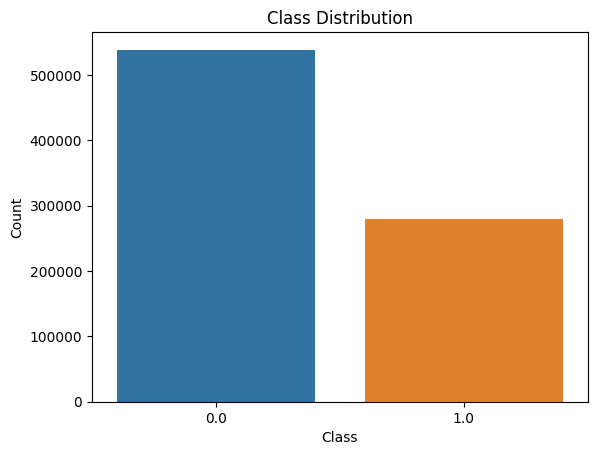

In [10]:
sns.countplot(data=data, x='Label', hue='Label', dodge=False, legend=False)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

## Data splitting

In [11]:
data = pd.DataFrame(data, columns=columns)

X = data.drop("Label", axis=1)
y = data["Label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(572766, 30) (245472, 30) (572766,) (245472,)


## Data class balancing

In [12]:
print("Original class distribution:\n", y_train.value_counts())

smote = SMOTE(sampling_strategy=0.8, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("After SMOTE:\n", y_train_smote.value_counts())


Original class distribution:
 Label
0.0    377163
1.0    195603
Name: count, dtype: int64
After SMOTE:
 Label
0.0    377163
1.0    301730
Name: count, dtype: int64


In [13]:
undersample = RandomUnderSampler(sampling_strategy=1, random_state=42)
X_train_resampled, y_train_resampled = undersample.fit_resample(X_train_smote, y_train_smote)

print("Resampled class distribution:\n", y_train_resampled.value_counts())

print(X_train_resampled.shape, X_test.shape, y_train_resampled.shape, y_test.shape)

Resampled class distribution:
 Label
0.0    301730
1.0    301730
Name: count, dtype: int64
(603460, 30) (245472, 30) (603460,) (245472,)


## Comparing 

### Bagging: Random Forest

In [44]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

deb = time.time()
rf_model.fit(X_train_resampled, y_train_resampled)
fin = time.time()

time_rf = fin-deb
print("Time taken:", time_rf)

start = time.time()
y_pred_rf = rf_model.predict(X_test)
end = time.time()
time_predict_rf = end-start

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"Random Forest - Accuracy: {accuracy_rf}, Precision: {precision_rf}, Recall: {recall_rf}, F1-Score: {f1_rf}")

Time taken: 753.5860948562622
Random Forest - Accuracy: 0.8317771476991266, Precision: 0.7330878416031994, Recall: 0.7990995390497516, F1-Score: 0.7646716892531087


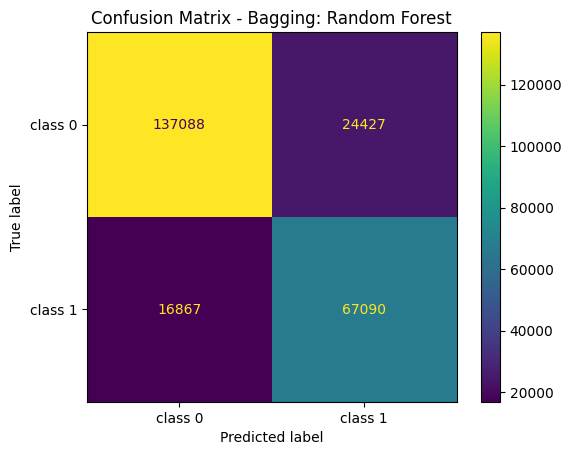

In [46]:
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1'])
disp.plot()
plt.title("Confusion Matrix - Bagging: Random Forest")
plt.show()

### Boosting: XGBoost

In [47]:
param_grid = {
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 1.0],     
    'colsample_bytree': [0.7, 1.0],
    'n_estimators': [100, 200],
    'reg_alpha': [0, 0.1],     
    'reg_lambda': [1, 10],  
}

xgb_clf = xgb.XGBClassifier(eval_metric='mlogloss', device='cuda')
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='f1', cv=3, verbose=1)
grid_search.fit(X_train_resampled, y_train_resampled)

print(f"Best parameters: {grid_search.best_params_}")

best_xgb_model = grid_search.best_estimator_


Fitting 3 folds for each of 128 candidates, totalling 384 fits


c:\Users\miche\Documents\Erasmus\DeVinci\Advanced ML II\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:04:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 1.0}


In [48]:
xgb_model = best_xgb_model

deb = time.time()
xgb_model.fit(X_train_resampled, y_train_resampled)
fin = time.time()

time_xgb = fin-deb
print("Time taken:", time_xgb)

start = time.time()
y_pred_xgb = xgb_model.predict(X_test)
end = time.time()
time_predict_xgb = end-start

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print(f"XGBoost - Accuracy: {accuracy_xgb}, Precision: {precision_xgb}, Recall: {recall_xgb}, F1-Score: {f1_xgb}")

Time taken: 1.9939377307891846
XGBoost - Accuracy: 0.8314919827923347, Precision: 0.7242751982476279, Recall: 0.8191693366842551, F1-Score: 0.7688051242496395


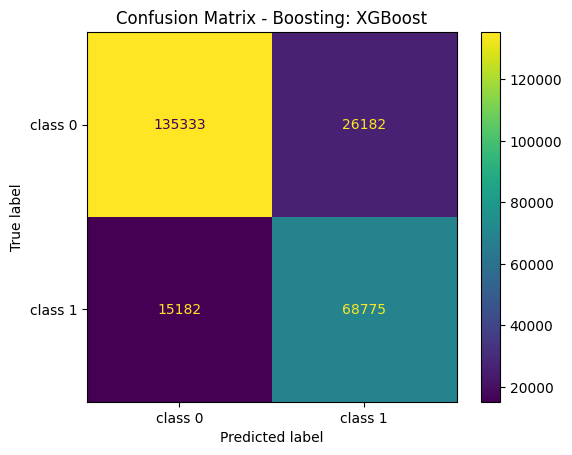

In [49]:
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1'])
disp.plot()
plt.title("Confusion Matrix - Boosting: XGBoost")
plt.show()

### 3. Evolutionary Learning Implementation with DEAP


In [14]:
pset = gp.PrimitiveSet("MAIN", X_train_resampled.shape[1])
pset.addPrimitive(np.add, 2)
pset.addPrimitive(np.subtract, 2)
pset.addPrimitive(np.multiply, 2)
pset.addPrimitive(np.negative, 1)
pset.addEphemeralConstant("rand", lambda: np.random.uniform(-1, 1))

pset.renameArguments(**{f"ARG{i}": f"x{i}" for i in range(X_train_resampled.shape[1])})

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=5)

population = toolbox.population(n=100)

c:\Users\miche\Documents\Erasmus\DeVinci\Advanced ML II\venv\Lib\site-packages\deap\gp.py:257: RuntimeWarning: Ephemeral rand function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


In [21]:
def eval_classifier(individual, X, y):
    func = toolbox.compile(expr=individual)
    predictions = [func(*x) > 0 for x in X.to_numpy()]
    return accuracy_score(y, predictions),
toolbox.register("evaluate", eval_classifier, X=X_train_resampled, y=y_train_resampled)

In [22]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

hof = tools.HallOfFame(1)

### Training eaSimple model

In [25]:
start = time.time()
population, logbook = algorithms.eaSimple(population, toolbox,
                                          cxpb=0.5,
                                          mutpb=0.2,
                                          ngen=5,
                                          stats=stats,
                                          halloffame=hof,
                                          verbose=True)
end = time.time()

time_deap_simple = end-start

best_individual = hof[0]

gen	nevals	avg     	std      	min     	max     
0  	45    	0.501348	0.0301067	0.321907	0.586702
1  	55    	0.521285	0.0323458	0.497473	0.646863
2  	71    	0.534657	0.0473338	0.366873	0.646863
3  	65    	0.554368	0.0546939	0.373372	0.646863
4  	57    	0.56476 	0.0696088	0.360508	0.646863
5  	59    	0.574054	0.0720607	0.358648	0.646863


### Training eaMuPlusLambda model

In [26]:
start = time.time()
population2, logbook2 = algorithms.eaMuPlusLambda(population, toolbox,
                                          mu=50,
                                          lambda_=100,
                                          cxpb=0.5,
                                          mutpb=0.2,
                                          ngen=5,
                                          stats=stats,
                                          halloffame=hof,
                                          verbose=True)
end = time.time()

time_deap_plus_lambda = end-start

best_individual2 = hof[0]

gen	nevals	avg     	std      	min     	max     
0  	0     	0.574054	0.0720607	0.358648	0.646863
1  	66    	0.635572	0.0241206	0.507018	0.646863
2  	68    	0.646541	0.00157687	0.638816	0.646863
3  	66    	0.646937	0.000362719	0.646863	0.648714
4  	68    	0.647011	0.000502162	0.646863	0.648714
5  	75    	0.647196	0.000711128	0.646863	0.648714


Metrics (DEAP Simple): {'Accuracy': 0.6453404054230217, 'Precision': np.float64(0.48623046875), 'Recall': np.float64(0.6523458437057065), 'F1': np.float64(0.557170251834972), 'Time': 1351.3653874397278}


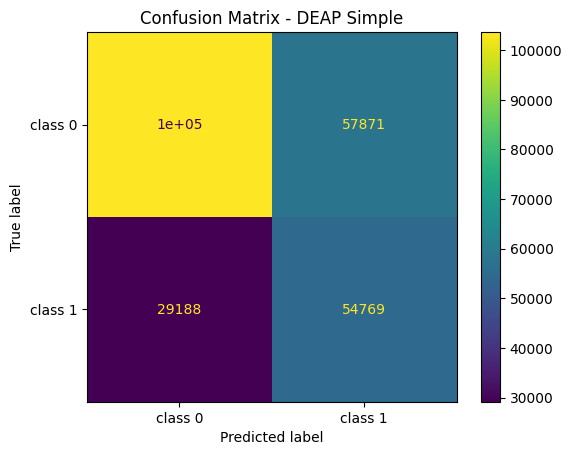

Metrics (DEAP + Lambda): {'Accuracy': 0.6576880458871073, 'Precision': np.float64(0.49966224894631184), 'Recall': np.float64(0.6255344998034709), 'F1': np.float64(0.5555579063174375), 'Time': 1239.173790693283}


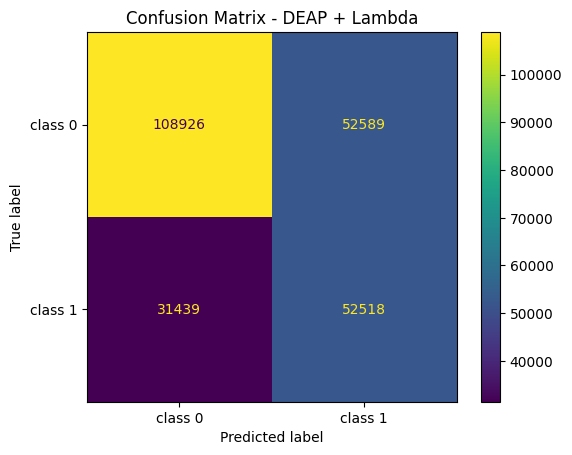

In [51]:
best_func = toolbox.compile(expr=best_individual)

start = time.time()
test_predictions = [best_func(*x) > 0 for x in X_test.to_numpy()]
end = time.time()

time_predict_deap_simple = end-start

accuracy_deap_simple = accuracy_score(y_test, test_predictions)
precision_deap_simple = precision_score(y_test, test_predictions)
recall_deap_simple = recall_score(y_test, test_predictions)
f1_deap_simple = f1_score(y_test, test_predictions)

metrics_deap_simple = {
    "Accuracy": accuracy_deap_simple,
    "Precision": precision_deap_simple,
    "Recall": recall_deap_simple,
    "F1": f1_deap_simple,
    "Time": time_deap_simple
}

print("Metrics (DEAP Simple):", metrics_deap_simple)

cm = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1'])
disp.plot()
plt.title("Confusion Matrix - DEAP Simple")
plt.show()

best_func2 = toolbox.compile(expr=best_individual2)

start = time.time()
test_predictions2 = [best_func2(*x) > 0 for x in X_test.to_numpy()]
end = time.time()
time_predict_deap_plus_lambda = end-start

accuracy_deap_plus_lambda = accuracy_score(y_test, test_predictions2)
precision_deap_plus_lambda = precision_score(y_test, test_predictions2)
recall_deap_plus_lambda = recall_score(y_test, test_predictions2)
f1_deap_plus_lambda = f1_score(y_test, test_predictions2)

metrics_deap_plus_lambda = {
    "Accuracy": accuracy_deap_plus_lambda,
    "Precision": precision_deap_plus_lambda,
    "Recall": recall_deap_plus_lambda,
    "F1": f1_deap_plus_lambda,
    "Time": time_deap_plus_lambda
}

print("Metrics (DEAP + Lambda):", metrics_deap_plus_lambda)

cm2 = confusion_matrix(y_test, test_predictions2)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=['class 0', 'class 1'])
disp2.plot()
plt.title("Confusion Matrix - DEAP + Lambda")
plt.show()

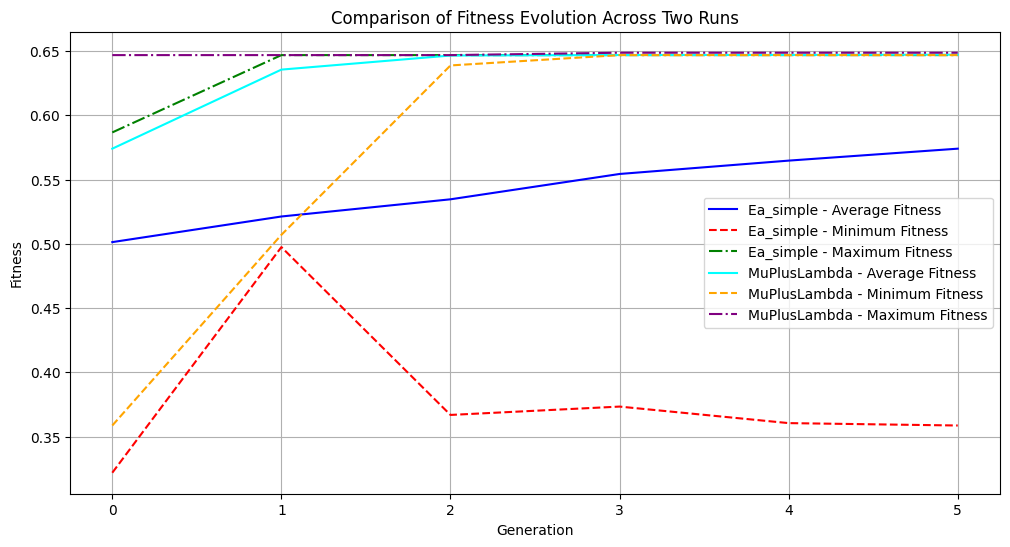

In [34]:
def plot_two_logbooks(logbook1, logbook2, labels=("Run 1", "Run 2")):
    gen1 = logbook1.select("gen")
    avg1 = logbook1.select("avg")
    min1 = logbook1.select("min")
    max1 = logbook1.select("max")

    gen2 = logbook2.select("gen")
    avg2 = logbook2.select("avg")
    min2 = logbook2.select("min")
    max2 = logbook2.select("max")

    plt.figure(figsize=(12, 6))

    plt.plot(gen1, avg1, label=f"{labels[0]} - Average Fitness", color="blue", linestyle="-")
    plt.plot(gen1, min1, label=f"{labels[0]} - Minimum Fitness", color="red", linestyle="--")
    plt.plot(gen1, max1, label=f"{labels[0]} - Maximum Fitness", color="green", linestyle="-.")

    plt.plot(gen2, avg2, label=f"{labels[1]} - Average Fitness", color="cyan", linestyle="-")
    plt.plot(gen2, min2, label=f"{labels[1]} - Minimum Fitness", color="orange", linestyle="--")
    plt.plot(gen2, max2, label=f"{labels[1]} - Maximum Fitness", color="purple", linestyle="-.")

    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Comparison of Fitness Evolution Across Two Runs")
    plt.legend()
    plt.grid()
    plt.show()

plot_two_logbooks(logbook, logbook2, labels=("Ea_simple", "MuPlusLambda"))


### Performance Evaluation 

### Comparative analysis

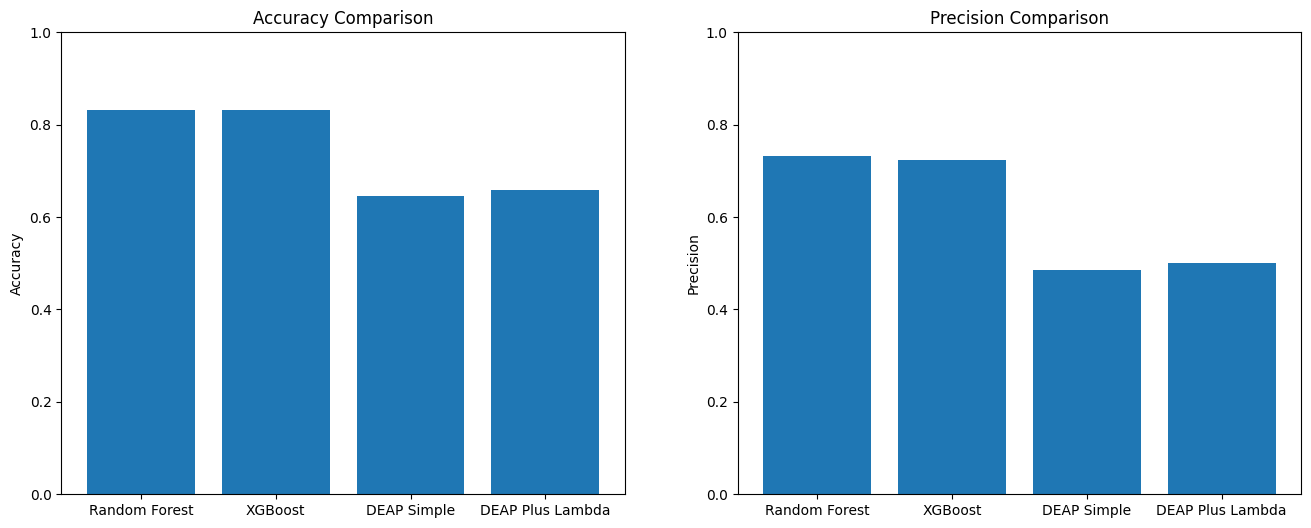

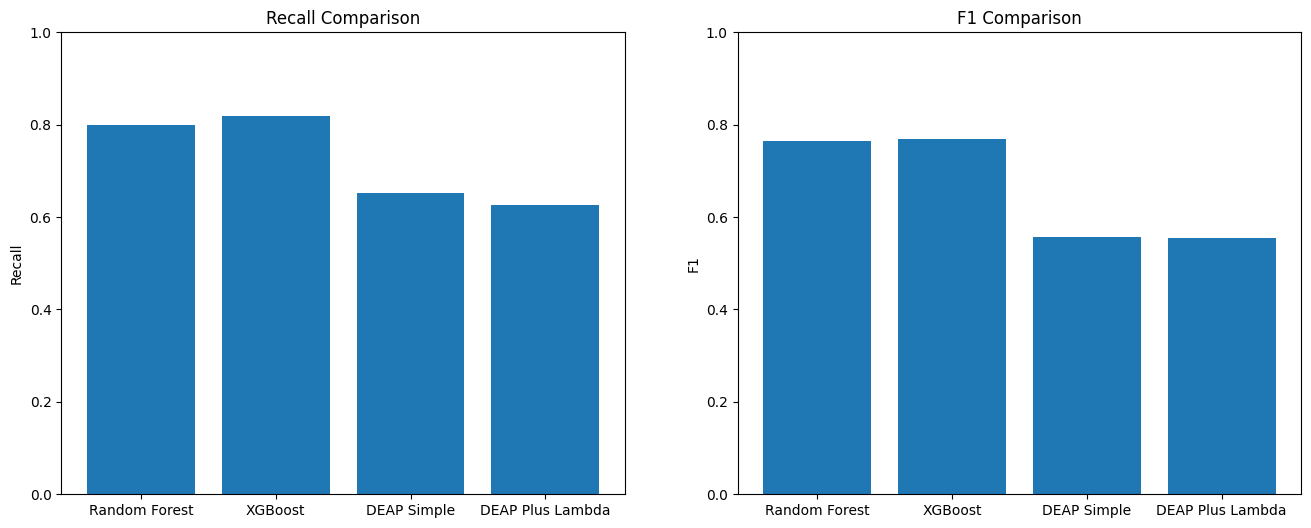

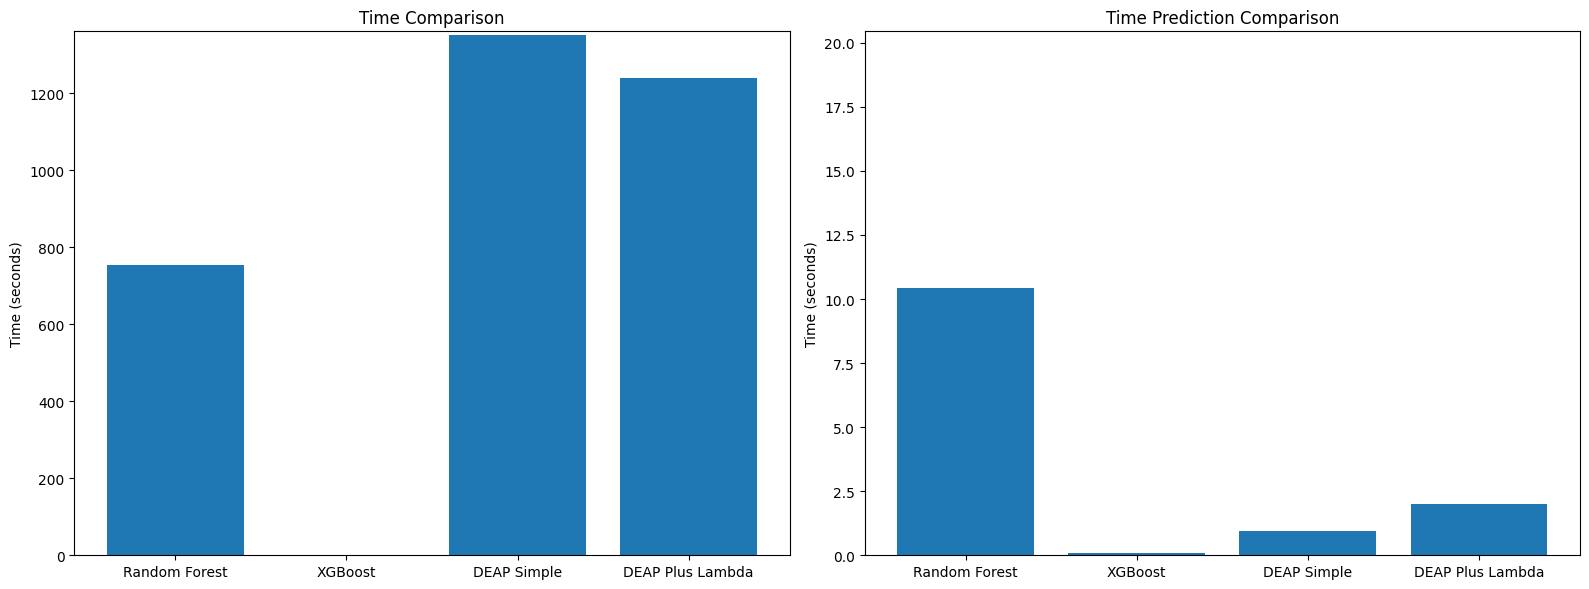

In [57]:
results = {
    "Random Forest": {"Accuracy": accuracy_rf, "Precision": precision_rf, "Recall": recall_rf, "F1": f1_rf, "Time": time_rf, "Time Prediction": time_predict_rf},
    "XGBoost": {"Accuracy": accuracy_xgb, "Precision": precision_xgb, "Recall": recall_xgb, "F1": f1_xgb, "Time": time_xgb, "Time Prediction": time_predict_xgb},
    "DEAP Simple": {"Accuracy": accuracy_deap_simple, "Precision": precision_deap_simple, "Recall": recall_deap_simple, "F1": f1_deap_simple, "Time": time_deap_simple, "Time Prediction": time_predict_deap_simple},
    "DEAP Plus Lambda": {"Accuracy": accuracy_deap_plus_lambda, "Precision": precision_deap_plus_lambda, "Recall": recall_deap_plus_lambda, "F1": f1_deap_plus_lambda, "Time": time_deap_plus_lambda, "Time Prediction": time_predict_deap_plus_lambda},
}

models = list(results.keys())
metrics = ["Accuracy", "Precision", "Recall", "F1"]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, metric in enumerate(metrics[:2]):
    axes[i].bar(models, [results[model][metric] for model in models])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].set_ylim(0, 1)
    
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, metric in enumerate(metrics[2:]):
    axes[i].bar(models, [results[model][metric] for model in models])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].set_ylim(0, 1)

fig_time, (ax_time, ax_time_prediction) = plt.subplots(1, 2, figsize=(16, 6))

ax_time.bar(models, [results[model]["Time"] for model in models])
ax_time.set_title('Time Comparison')
ax_time.set_ylabel('Time (seconds)')
ax_time.set_ylim(0, max(results[model]["Time"] for model in models) + 10)

ax_time_prediction.bar(models, [results[model]["Time Prediction"] for model in models])
ax_time_prediction.set_title('Time Prediction Comparison')
ax_time_prediction.set_ylabel('Time (seconds)')
ax_time_prediction.set_ylim(0, max(results[model]["Time Prediction"] for model in models) + 10)

plt.tight_layout()
fig_time.tight_layout()

plt.show()
